# Recurrent Neural Networks

In today's lecture, we cover **Recurrent Neural Networks (RNNs)** a specific network architecture designed for processing  sequence data. We specifically deal with two prominent use cases, namely time series and language data. In addition, RNNs play a pivotal role for reinforcement learning as well as for the analysis and geenration of music and videos.

In order to represent text as data, we have several options such as encoding single characters or words, or even groups of words - called *n-grams*. However, none of these representations is nicely compatible with MLPs. 

Indeed, first MLPs expect a fixed-length input, whereas sentences can arguably be of very different length, as the following quotes illustrate:

Barack Obama

> Yes, we can

Immanuel Kant

> Ist
dieses nun nicht geschehen, und kann es auch, wegen der Untauglichkeit
des gemeinen Menschenverstandes zu so subtiler Spekulation, niemals
erwartet werden; hat vielmehr, was das erstere betrifft, die jedem
Menschen bemerkliche Anlage seiner Natur, durch das Zeitliche (als
zu den Anlagen seiner ganzen Bestimmung unzulänglich) nie zufrieden
gestellt werden zu können, die Hoffnung eines künftigen Lebens, in
Ansehung des zweiten die bloße klare Darstellung der Pflichten im
Gegensatze aller Ansprüche der Neigungen das Bewußtsein der Freiheit,
und endlich, was das dritte anlangt, die herrliche Ordnung, Schönheit
und Fürsorge, die allerwärts in der Natur hervorblickt, allein den
Glauben an einen weisen und großen Welturheber, die sich aufs Publikum
verbreitende Überzeugung, sofern sie auf Vernunftgründen beruht,
ganz allein bewirken müssen: so bleibt ja nicht allein dieser Besitz
ungestört, sondern er gewinnt vielmehr dadurch noch an Ansehen,
daß die Schulen nunmehr belehrt werden, sich keine höhere und
ausgebreitetere Einsicht in einem Punkte anzumaßen, der die allgemeine
menschliche Angelegenheit betrifft, als diejenige ist, zu der die
große (für uns achtungswürdigste) Menge auch eben so leicht gelangen
kann, und sich also auf die Kultur dieser allgemein faßlichen und in
moralischer Absicht hinreichenden Beweisgründe allein einzuschränken.

In addition, in text the appearance of one character or word typically has a strong influence on the following ones. This is also reflected poorly in MLPs.

Having these insufficies of MLPs in mind lead to the development of **recurrent neural networks (RNNs)** as illustrated below in a [wonderful blogpost by Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) 


<img src="images/rnn.png"  style="width: 500px;"/>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In the figure above, the variables $x_i$ denote sequential input such as characters or words. The symbol $A$ represents a network combining the information of the current input together with a previous output in order to obtain more refined view. The value $h_i$ can be an output of any kind, such as for instance a prediction for the most probable following character.

The training mechanism of RNNs relies on **backpropagation through time (BPTT)**. Essentially, BPTT means considering the RNN as a feed-forward neural network and applying the standard backpropagation, as encountered in a [previous lecture](./backprop.html).

The only caveat is that each weight appears once in each layer and typically the gradient signals in different layers do not agree. Hence, what is done in BPTT is to update the weights by the sum of the gradients from each of the layers.

### Long Short-Term Memory Networks

Although RNNs manage to capture sequential dependencies, they are myopic in the sense that incorporating information of more than two or three steps in the past remains very difficult. However, when analyzing language data it is quite common to see dependencies spanning over the entire sentence. Let me just mention that Germans love to put verbs at the end of a sentence!

At the heart of this limitation lies the  **vanishing gradient problem**. That is, if information should be taken into account over long ranges in the sentence, then in the backpropagation mechanism the gradient signal needs to travel over many steps and therefore becomes very weak. To combat the vanishing gradient problem, in 1997 [Sepp Hochreiter and Jürgen Schmidhuber](https://www.ncbi.nlm.nih.gov/pubmed/9377276) developed the **long short-term memory (LSTM) networks**.

The principal idea behind LSTM networks is the introduction of gates allowing gradients to travel across many layers without diminishing their strength after every step. Here is another beautiful illustration from [Christopher Olah's blogpost](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

<img src="images/lstm.png" style="width: 500px;"/>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In ``Keras`` LSTMs are available as a layer.

In [1]:
library(keras)

cell_size <- 32
input_dim <- 26

model <- keras_model_sequential()
model %>%
 layer_lstm(cell_size, input_shape = list(NULL, input_dim)) %>%
 layer_dense(1)
model

Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_1 (LSTM)                       (None, 32)                      7552        
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       33          
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
________________________________________________________________________________



In order to understand the concept of gates, we take a closer look at the defining equations of the LSTM. The central architectural unit of an LSTM is a *cell* storing information stemming from possibly distant relevant parts of the input. At time step $t$ the cell state $C_t \in \mathbb{R}^h$ is a linear combination of the cell state $C_{t-1}$ in the previous step and an **update vector** $\tilde{C}_{t-1}$:
$$C_t = f_t \cdot C_{t-1} +  i_t \cdot \tilde{C}_{t}$$

Here, the coefficients $f_t, i_t \in [0,1]^h$ and the update vector $\tilde{C}_{t} \in [-1,1]^h$ are determined as follows. The coefficient $f_{t}$ is called **forget gate** and determines how much of the information from the previous cell should be retained. It is computed via a single-layer MLP with sigmoid-activation from the current input $x_t$ and the output $h_{t-1}$ from the previous step:
$$f_t = \sigma(W_{{\mathsf{f}}}[x_t; h_{t-1}] + b_{\mathsf{f}})$$

Similarly, the **input gate** $i_t$ determines how much of the update vector is incorporated in the $t$th step:
$$i_t = \sigma(W_{{\mathsf{i}}}[x_t; h_{t-1}] + b_{\mathsf{i}})$$

The update vector $\tilde{C}_{t}$ is also obtained as a single-layer MLP, but using a $\tanh$-activation instead:
$$\tilde{C}_t = \tanh(W_{{\mathsf{C}}}[x_t; h_{t-1}] + b_{\mathsf{C}})$$

The final step in the LSTM cell is to relate the output $h_t$ to the current cell state $C_t$:
$$h_t = o_t \cdot \tanh(C_t),$$
with the **output gate** 
$$o_t = \sigma(W_{{\mathsf{o}}}[x_t; h_{t-1}] + b_{\mathsf{o}}).$$

## Text Generation

Before applying LSTMs to time series data, we venture into the domain of NLP. Here, we follow in large parts [Chapter 8.1 of *Deep Learning with Python*](https://github.com/jjallaire/deep-learning-with-r-notebooks/blob/master/notebooks/8.1-text-generation-with-lstm.Rmd). So, how can we get RNNs to generate text for us?

The basic idea is simple. We consider text as a sequence of suitably encoded characters and then train an RNN for predicting the most probable next character. We explore the strengths and weaknesses of this method by generating text from Nietzsche.

#### Data Preprocessing

First, we load the text and one-hot encode the characters.

In [1]:
library(stringr)
library(keras)
library(abind)

path <- "./data/nietzsche.txt"
text <- tolower(readChar(path, file.info(path)$size))

Next, we split it into shorter sequences of length ``maxlen = 60``. To enhance diversity, we perform sub-sampling and only take every third possible sequence. For each of these sequences, we also keep the following character.

In [3]:
maxlen <- 60
step <- 3

txt_idxs <- seq(1, nchar(text) - maxlen, by = step)

sentences <- str_sub(text, txt_idxs, txt_idxs + maxlen - 1)
next_chars <- str_sub(text, txt_idxs + maxlen, txt_idxs + maxlen)
nsents <- length(sentences)

Next, we collect all occurring characters in an array and construct a dictionary mapping each character to the position in this array. 

In [4]:
chars <- unique(sort(strsplit(text, "")[[1]]))
nchars <- length(chars)

char_idxs <- 1:nchars
names(char_idxs) <- chars

We use an auxiliary function to one-hot encode a text

In [7]:
ohe_char <- function(char){
    #' Create one-hot embedding of a string
    #' 
    #' Replace each character by corresponding unit vector
    #' 
    #' @param char character to embed
    
    char_emb <- array(0L, dim = nchars)
    char_emb[char_idxs[[char]]] <- 1
    char_emb
}

ohe_string <- function(string){
    #' Create one-hot embedding of a string
    #' 
    #' Replace each character by corresponding unit vector
    #' 
    #' @param string string to embed
    
  string_emb <- array(0L, dim = c(maxlen, nchars))
  char_seq <- strsplit(string, "")[[1]]
  for (t in 1:maxlen) 
      string_emb[t, ] <- ohe_char(char_seq[[t]])
    string_emb
}

In the final step, we perform a one-hot embedding of the data. In view of the desired input format for LSTMs, the sequence of sentences is stored in an array of shape ``(nsents, maxlen, nchars))``.

In [6]:
x <- array(0L, dim = c(nsents, maxlen, nchars))
y <- array(0L, dim = c(nsents, nchars))

for (i in 1:nsents) {
  x[i,,] <- ohe_string(sentences[[i]])
  y[i,] <- ohe_char(next_chars[[i]])
}

#### Model Architecture

As architecture, we choose a single-layer LSTM .

In [9]:
cell_size <- 128

model <- keras_model_sequential()
model %>%
 layer_lstm(cell_size, input_shape = list(maxlen, nchars)) %>%
 layer_dense(nchars, activation = "softmax")

We optimize it with respect to crossentropy.

In [12]:
lr <- 1e-2

model %>% compile(
  loss = "categorical_crossentropy", 
  optimizer = optimizer_rmsprop(lr)
)   

Now, we train the model.

In [15]:
model %>%
 fit(x,y , epochs = 5, batch_size = 2048)

Note that the last layer of the model is a softmax layer over the characters. In order to use the model for text-generation, we need to convert these probabilities into actual characters. 

For this purpose, we take from [François Chollets notebook](https://github.com/jjallaire/deep-learning-with-r-notebooks/blob/master/notebooks/8.1-text-generation-with-lstm.Rmd) a sampling function of characters depending on the activations in the final layer. This sampling function depends on a temperature parameter interpolating between a uniform distribution and a Dirac distribution on the most likely character.

In [16]:
sample_next_char <- function(preds, temperature = 1.0) {
  preds <- as.numeric(preds)
  preds <- log(preds) / temperature
  exp_preds <- exp(preds)
  preds <- exp_preds / sum(exp_preds)
  which.max(t(rmultinom(1, 1, preds)))
}

Now, we can see how the sampling works for the fitted model. We start at an random initial starting segment.

In [17]:
start_index <- sample(1:nchar(text), 1)  
seed_text <- str_sub(text, start_index, start_index + maxlen - 1)
seed_text

[1] "suffer? and our sympathy--do ye not understand\nwhat our reve"

Now, we take the previously fitted model and apply the sampling scheme.

In [26]:
generated_text <- seed_text
temperature <- .5
nchargen <- 400

for (i in 1:nchargen) {

 #one-hot encode the generated text
  sampled <- ohe_string(generated_text)

  #compute probabilities of next char and sample
  preds <- model %>% 
    predict(sampled, verbose = 0)
  next_index <- sample_next_char(preds[1,], temperature)
  next_char <- chars[[next_index]]

  #update the generated text by adding a final character 
  generated_text <- paste0(generated_text, next_char)
  generated_text <- substring(generated_text, 2)

  cat(next_char)
}

lly and athor in the lat ald dent and the gret in al alll the salt the tint in the the gals erped be that aly in the that the  of the dor are the d malt of and "the malle of the gint and it and aly the gy the gand of the galt whet and the lond of the gins its ard the sof of the grtres in mand a der thet and in al aly and the grere the gon aly the gand ba the golt in the nof of the mant the gon of 

We see that RNNs can make steps into imitating Nietzsche! However, a closer look reveals that this approach produces examples sticking rather closely to the original text. Developing different generative models not suffering so strongly  from this problem is a vibrant area of research in AI.

After more training, the sentences would become even better. Here are examples from [Andrej Karpathy's blogpost](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) trained on Shakespeare.

>  VIOLA:
Why, Salisbury must find his flesh and thought
That which I am not aps, not a man and in fire,
To show the reining of the raven and the wars
To grace my hand reproach within, and not a fair are hand,
That Caesar and my goodly father's world;
When I was heaven of presence and our fleets,
We spare with hours, but cut thy council I am great,
Murdered and by thy master's ready there
My power to give thee but so much as hell:
Some service in the noble bondman here,
Would show him to her wine.

>KING LEAR:
O, if you were a feeble sight, the courtesy of your law,
Your sight and several breath, will wear the gods
With his heads, and my hands are wonder'd at the deeds,
So drop upon your lordship's head, and your opinion
Shall be against your honour.

#### 9.30

#### 10.05

### Temperature Data

After letting LSTMs speak Nietzsche, we explore how useful LSTM are when working with standard numerical time series. Here, we follow [François Chollets notebook](https://github.com/jjallaire/deep-learning-with-r-notebooks/blob/master/notebooks/6.3-advanced-usage-of-recurrent-neural-networks.Rmd) on the analysis of German weather data: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [2]:
library(readr)
library(tibble)

data <- read_csv('./data/jena_climate_2009_2016.csv')

Parsed with column specification:
cols(
  `Date Time` = col_character(),
  `p (mbar)` = col_double(),
  `T (degC)` = col_double(),
  `Tpot (K)` = col_double(),
  `Tdew (degC)` = col_double(),
  `rh (%)` = col_double(),
  `VPmax (mbar)` = col_double(),
  `VPact (mbar)` = col_double(),
  `VPdef (mbar)` = col_double(),
  `sh (g/kg)` = col_double(),
  `H2OC (mmol/mol)` = col_double(),
  `rho (g/m**3)` = col_double(),
  `wv (m/s)` = col_double(),
  `max. wv (m/s)` = col_double(),
  `wd (deg)` = col_double()
)


Next, we visualize the temperature time series.

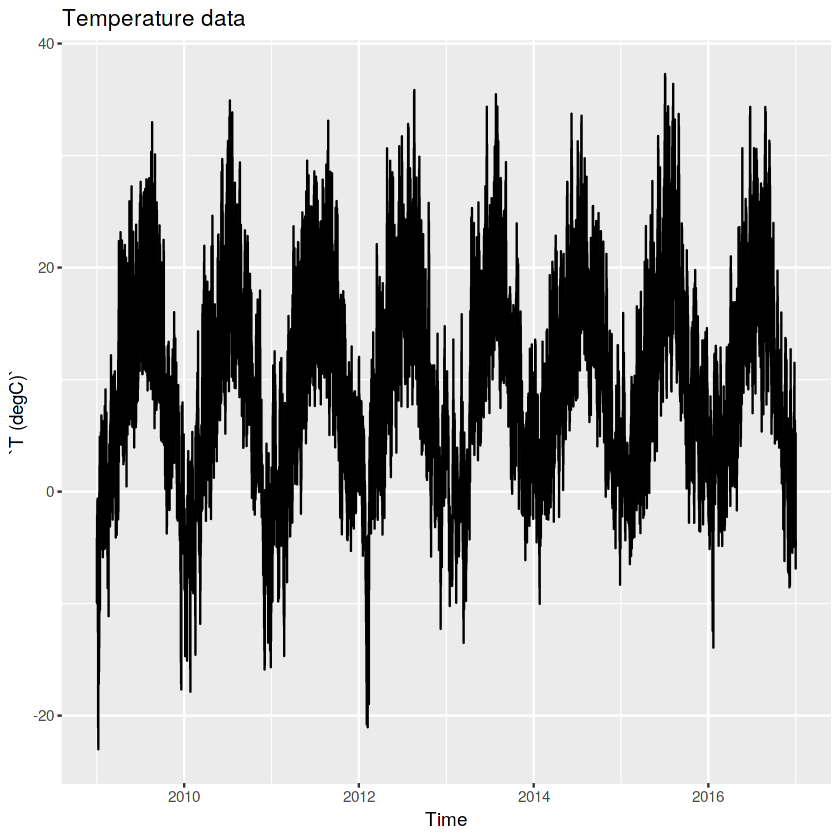

In [3]:
library(ggplot2)
ggplot(data, 
       aes(x = as.Date(data[,1][[1]], 
                       format = c("%d.%m.%Y %H:%M:%OS")),
            y = `T (degC)`)
      ) + 
    geom_line() + 
    xlab('Time') + 
    ggtitle('Temperature data')

When analyzing numeric data via deep learning, it is crucial to standardize the input. We restrict on the first 300,000 data points as training sample and remove the time stamp.

In [4]:
trn_size <- 3e5
data <- data[, -1]
trn_data <- data.matrix(data[1:trn_size,])

mean <- apply(trn_data, 2, mean)
std <- apply(trn_data, 2, sd)
data <- scale(data, center = mean, scale = std)

####  Network Architecture

 As network architecture, we choose an LSTM unit with cellsize 32 and optimize it with respect to mse.

In [5]:
library(keras)

cell_size = 32

model <- keras_model_sequential()
model %>%
 layer_lstm(cell_size, input_shape = list(NULL, dim(data)[2])) %>%
 layer_dense(1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

#### Training

In order to feed the network with training data, we need to break it up into chunks of a manageable size.

For that purpose, we adapt [François Chollets notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb) and use a generator adapted to chop the data into smaller pieces.

In [13]:
generator <- function(data, 
                      lookback = 1440, #size of history considered for prediction 
                      delay = 1,  #prediction interval into the future
                      batch_size = 128, #batch size for sgd
                      step = 6) #subsampling 
{ 
  function() {
    rows <- sample(c((1 + lookback):trn_size), batch_size)
    
    samples <- array(0, dim = c(batch_size, 
                                lookback / step,
                                dim(data)[2]))
    targets <- array(0, dim = c(batch_size))
                     
    for(i in 1:batch_size) {
      #get data from history
      idxs <- seq(rows[[i]] - lookback, rows[[i]] - 1, 
                     by = step)
      samples[i,,] <- data[idxs,]
        
      #get data from future, only extract temperature
      targets[[i]] <- data[rows[[i]] + delay, 2]
    }            
    list(samples, targets)
  }
}

Now, we define generators for training data.

In [14]:
lookback <- 1440
step <- 6
delay <- 144
batch_size <- 128

train_gen <- generator(
  data,
  lookback = lookback,
  delay = delay,
  step = step, 
  batch_size = batch_size
)

Now, we perform the actual training.

In [15]:
epoch_steps <- floor(trn_size/batch_size)

history <- model %>%
fit_generator(train_gen, epochs = 1, steps_per_epoch = epoch_steps)

### Summary

LSTMs are a versatile tool for prediction problems relating to time series. However, at the time of writing, there is no yet a clear consentssus on how they perform in comparison to more classical methods from time-series analysis such as [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) or [Holt-Winters](https://en.wikipedia.org/wiki/Exponential_smoothing) models.

As a rule of thumb, for univariate time series depending on a small number of covariates LSTMs are easily outperformed by established approaches from time series analysis. However, when dealing with multi-variate time series involving complex dependencies, carefully designed LSTMs often gain an edge. This is true in particular when using the [Seq2Seq architecture](https://google.github.io/seq2seq/) that we discuss in the problem class.

#### 10.45